<a href="https://colab.research.google.com/github/SethMinor/PyWSINDy-for-PDEs/blob/main/wsindy_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **WSINDy for PDEs: Examples**

- Based on the [JCP paper by **D. A. Messenger**, **D. M. Bortz** (2021)](https://www.sciencedirect.com/science/article/pii/S0021999121004204).
- See the authors' original [MatLab code repository](https://github.com/MathBioCU/WSINDy_PDE).

Seth Minor, 2025

---

This notebook illustrates the Weak SINDy algorithm being applied to various spatiotemporal systems:
- the $(1+1)$-dimensional Kuramoto Sivashinsky equation
- the $(2+1)$-dimensional Swift Hohenberg equation
- the $(3+1)$-dimensional MHD equations

In [1]:
%pip install symengine

!wget -q https://raw.githubusercontent.com/SethMinor/PyWSINDy-for-PDEs/main/wsindy.py
!wget -q https://raw.githubusercontent.com/SethMinor/PyWSINDy-for-PDEs/main/helper_fcns.py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 MB 15.0 MB/s eta 0:00:00


In [2]:
import torch
import scipy
import numpy as np
import itertools
import symengine as sp

import torch.linalg as la
from scipy.signal import convolve
from scipy.special import factorial
import matplotlib.pyplot as plt
from tqdm import tqdm

from wsindy import *
from helper_fcns import *

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/WSINDy

file_path = '/content/drive/My Drive/WSINDy'

Mounted at /content/drive
/content/drive/My Drive/WSINDy


## **KURAMOTO SIVASHINKSY**

In this example, we use data from a numerical solution of the $(1+1)$-dimensional Kuramoto Sivashinsky equation: \begin{align*}
u_t = -\frac{1}{2}\left(u^2\right)_{x} - u_{xx} - u_{xxxx},
\quad \text{for} \quad
\begin{cases}
x \in [0, \, 32\pi],
\\
\, t \in [0, \, 150],
\end{cases}
\end{align*} using periodic boundary conditions. See the `KS.txt` file (1.3 MB) located [here](https://github.com/SethMinor/PyWSINDy-for-PDEs/blob/main/Datasets/KS.txt). These data were sourced from [this GitHub repository](https://github.com/MathBioCU/WSINDy_PDE/blob/master/datasets/KS.mat).

In [4]:
noise = 0.2

Imported tensor with shape (256, 301)


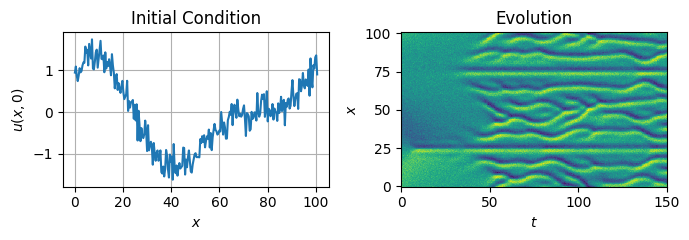

In [5]:
data_path = file_path + '/Kuramoto Sivashinsky/KS.txt'

# Read in CSV data
U = np.loadtxt(data_path, delimiter=',')
if noise == 0:
  U = torch.tensor(U)
else:
  U = torch.tensor(U)
  U = add_noise(U, noise)

# Reshape to Nx x ... x Nt tensor
[L, T] = [32*np.pi, 150]
[Nx, Nt] = [256, 301]
U = U.view(Nx, -1)
print(f"Imported tensor with shape {U.numpy().shape}")

# Space and time
x = torch.linspace(0, L, Nx)
t = torch.linspace(0, T, Nt)

# Plot the data
fig,ax = plt.subplots(1,2,figsize=(7,2.5))

IC = U[:,1]
ax[0].plot(x, U[:,0])
ax[0].set_title('Initial Condition')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$u(x,0)$')
ax[0].grid(True)

X,T = torch.meshgrid(x, t, indexing='ij')
ax[1].pcolormesh(T, X, U)
ax[1].set_title('Evolution')
ax[1].set_xlabel('$t$')
ax[1].set_ylabel('$x$')

fig.tight_layout()
plt.show()
del fig,ax,X,L,T,Nx,Nt,IC

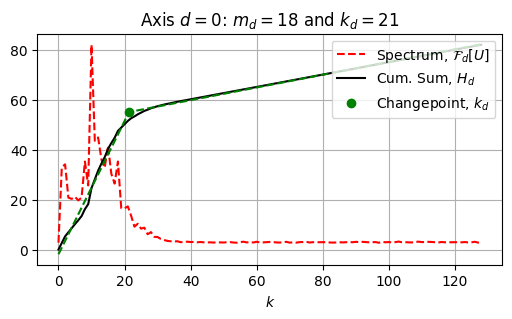

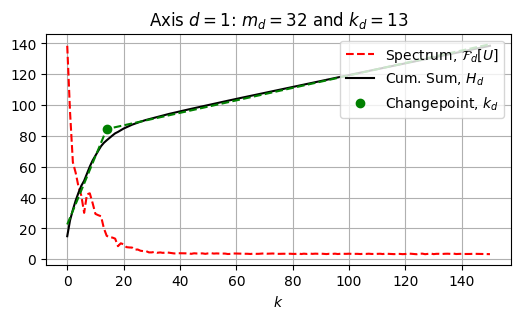

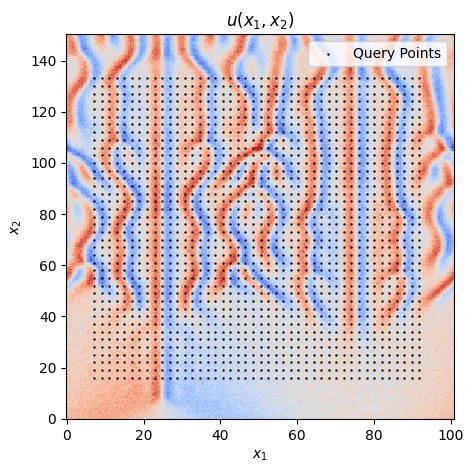

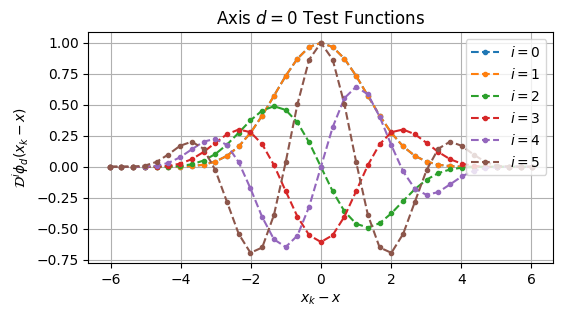

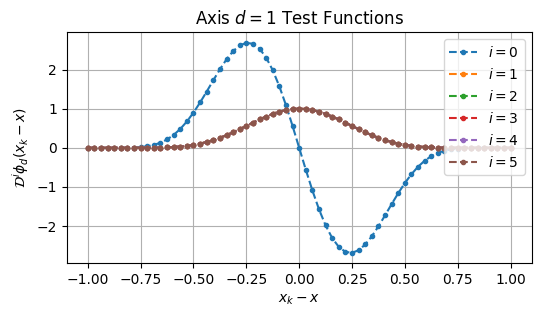

In [6]:
X = [x,t]

# Derivatives for test fcns
alpha = [[0,1],
         [0,0],
         [1,0],
         [2,0],
         [3,0],
         [4,0]]

# Powers for homogeneous fcns
beta = [[0],
        [1],
        [2]]

model = WSINDy(U, alpha, beta, X)

In [7]:
# CREATE LIBRARY

# Create standard library terms
[G,powers,derivs,rhs_names] = model.create_default_library()

# Add a funky non-homogeneous term, e.g., D^i cos(u)
i = 1
kernel = [model.axes[d][i,:] for d in range(U.ndim)]
yxyt = np.prod(model.yx + [model.yt])
cos_term = compute_weak_trig(U, kernel, model.spacing, freq=1., phase=0., yxyt=yxyt)

G.append(cos_term[model.conv_mask])
powers.append([0])
derivs.append(i)
rhs_names.append(r'\cos(u)' + model.derivative_names[i])

del i, yxyt, kernel, cos_term

100%|██████████| 5/5 [00:00<00:00, 57.54it/s]


In [8]:
# Display the library in LaTeX
from IPython.display import display, Math

lib_string = r'\Theta=' + r'\{' + r', \, '.join(rhs_names) + r'\}'
display(Math(lib_string))

<IPython.core.display.Math object>

In [9]:
# Set lhs
lhs_name = 'u' + model.derivative_names[0]
model.build_lhs(lhs_name)

# Set library
model.set_library(G, powers, derivs, rhs_names)

# Find sparse weights
w = model.MSTLS()
model.print_report()

HYPER-PARAMETERS
m = [18, 32]
p = [11, 9]
s = [5, 6]
[yx, yt] = [0.849, 0.062]
yu = 0.741
Aux. scales = []

LIBRARY
Num. query points = 1760
Num. terms = 12
cond(G) = 6.538e+01

RESULTS
PDE: u_{t} = - 0.50(u^2)_{x} - 1.00(u)_{xx} - 1.00(u)_{xxxx}
Nonzero terms = 3
Rel. L2 error = 0.139
R^2 = 0.981
Lambda = 7.197e-02
Loss = 0.266


In [10]:
pde = symbolic_pde(model.lhs_name, model.rhs_names, model.coeffs)
display(Math(pde))

<IPython.core.display.Math object>

In [11]:
# Reset variables for next example
del U, model, X, x, t, alpha, beta
del powers, derivs, lhs_name, rhs_names, lib_string
del G, w, noise, pde

## **SWIFT HOHENBERG**

These data are taken from a numerical simulation of the $(2+1)$-dimensional Swift Hohenberg equation: \begin{align*}
u_t = (r-1)u + \delta{u}^2 - u^3
- \left(2u_{xx} + 2u_{yy}\right)
- \left(u_{xxxx} + 2u_{xxyy} + u_{yyyy}\right),
\quad \text{for} \quad
\begin{cases}
x \in [0, 30\pi],
\\
y \in [0, 30\pi],
\\
t \in [0, 20],
\end{cases}
\end{align*} with parameters $r = 0.4$ and $\delta = 1$.

This comes example comes from MatLab's `Chebfun` package, see [this link](https://www.chebfun.org/examples/pde/SwiftHohenberg.html). Since the `SH23.txt` file (70.8 MB) is too big to store on GitHub, we provide [some MatLab code](https://github.com/SethMinor/PyWSINDy-for-PDEs/blob/main/Datasets/SH23_simulation.m) that runs the simulation locally.

In [12]:
noise = 0.1

Imported tensor with shape (200, 200, 101)


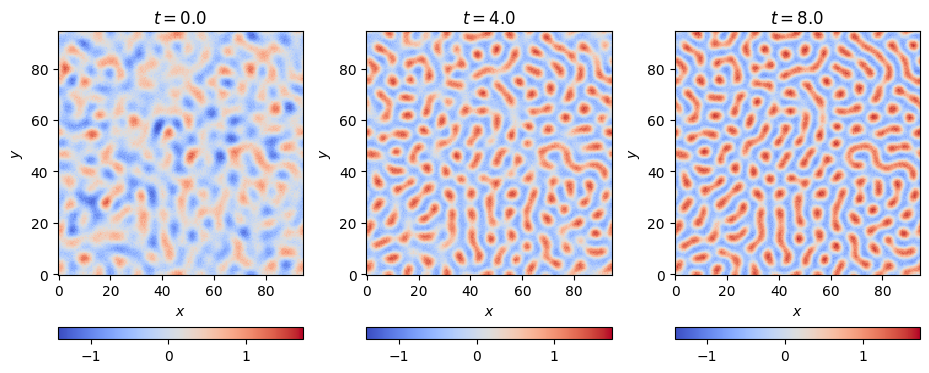

In [13]:
data_path = file_path + '/Swift Hohenberg 23/SH23.txt'

# Read in CSV data
U = np.loadtxt(data_path, delimiter=',')
if noise == 0:
  U = torch.tensor(U)
else:
  U = torch.tensor(U)
  U = add_noise(U, noise)

# Reshape to Nx x ... x Nt tensor
[L, W, T] = [30*np.pi, 30*np.pi, 20]
[Nx, Ny, Nt] = [200, 200, 101]
U = U.view(Nx, Ny, -1)
print(f"Imported tensor with shape {U.numpy().shape}")

# Space and time
x = torch.linspace(0, L, Nx)
y = torch.linspace(0, W, Ny)
t = torch.linspace(0, T, Nt)

# Plot the data
skip = 20
X,Y = np.meshgrid(x.numpy(), y.numpy())

fig,ax = plt.subplots(1,3,figsize=(9.4,4))
for j in range(3):
  Unp = U[:,:,skip*j].numpy()
  im = ax[j].pcolormesh(X, Y, Unp.T, cmap='coolwarm', vmin=U.min(), vmax=U.max())
  plt.colorbar(im, orientation='horizontal')
  ax[j].set_xlabel('$x$')
  ax[j].set_ylabel('$y$')
  ax[j].set_title(f'$t = {t[skip*j]}$')

fig.tight_layout()
plt.show()

del X,Y,L,W,T,Nx,Ny,Nt
del skip,j,Unp,fig,ax,im

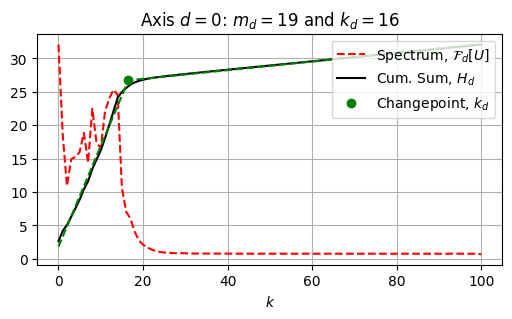

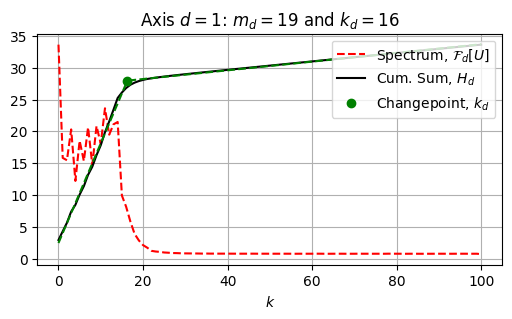

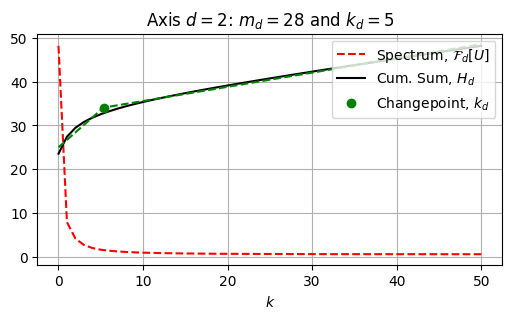

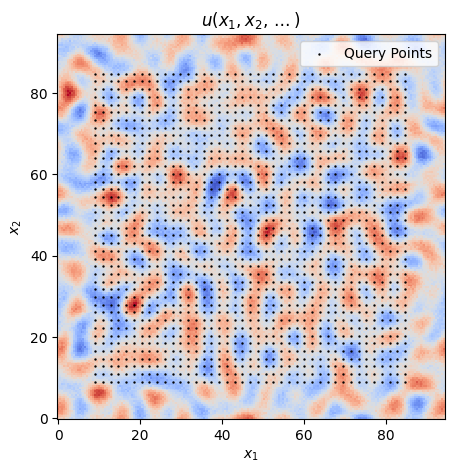

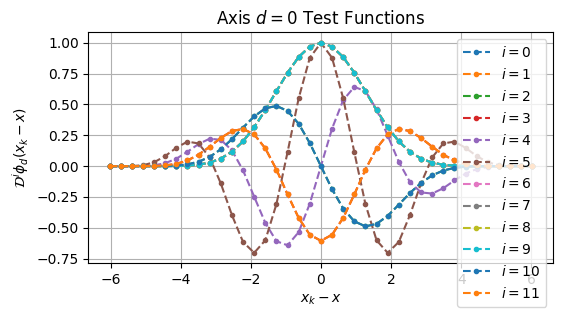

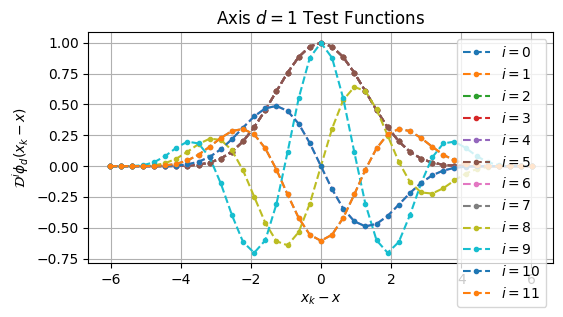

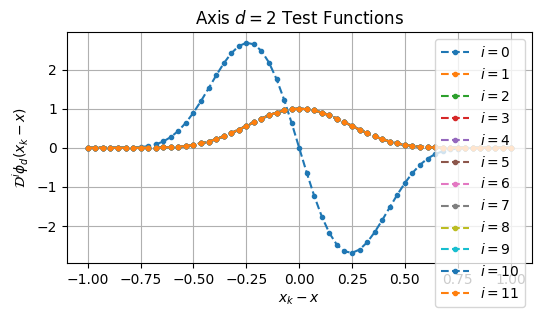

In [14]:
X = [x,y,t]

# Derivatives for test fcns
alpha = [[0,0,1],
         [0,0,0],
         [1,0,0],
         [2,0,0],
         [3,0,0],
         [4,0,0],
         [0,1,0],
         [0,2,0],
         [0,3,0],
         [0,4,0],
         [1,1,0],
         [2,2,0],]

# Powers for homogeneous fcns
beta = [[0],
        [1],
        [2],
        [3]]

model = WSINDy(U, alpha, beta, X)

In [15]:
# Create standard library terms
[G,powers,derivs,rhs_names] = model.create_default_library()

100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


In [16]:
# Display the library in LaTeX
from IPython.display import display, Math

lib_string = r'\Theta=' + r'\{' + r', \, '.join(rhs_names) + r'\}'
display(Math(lib_string))

<IPython.core.display.Math object>

In [17]:
# We can remove some crazy high-order terms
remove_cols = [6,8,9,11,12,14,15] + [18,20,21,23,24,26,27] + [30,32,33]

for column in sorted(remove_cols, reverse=True):
  G.pop(column)
  powers.pop(column)
  derivs.pop(column)
  rhs_names.pop(column)

lib_string = r'\Theta=' + r'\{' + r', \, '.join(rhs_names) + r'\}'
display(Math(lib_string))

del remove_cols, column

<IPython.core.display.Math object>

In [18]:
# Set lhs
lhs_name = 'u' + model.derivative_names[0]
model.build_lhs(lhs_name)

# Set library
model.set_library(G, powers, derivs, rhs_names)

# Find sparse weights
w = model.MSTLS()
model.print_report()

HYPER-PARAMETERS
m = [19, 19, 28]
p = [11, 11, 9]
s = [4, 4, 2]
[yx, yt] = [0.67, 0.67, 0.179]
yu = 0.959
Aux. scales = []

LIBRARY
Num. query points = 38663
Num. terms = 17
cond(G) = 2.953e+02

RESULTS
PDE: u_{t} = - 0.57(u) + 0.96(u^2) - 0.97(u^3) - 1.94(u)_{xx} - 0.97(u)_{xxxx} - 1.95(u)_{yy} - 0.97(u)_{yyyy} - 1.94(u)_{xxyy}
Nonzero terms = 8
Rel. L2 error = 0.143
R^2 = 0.978
Lambda = 1.931e-02
Loss = 0.511


In [19]:
pde = symbolic_pde(model.lhs_name, model.rhs_names, model.coeffs)
display(Math(pde))

<IPython.core.display.Math object>

In [20]:
# Reset variables for next example
del U, model, X, x, y, t, alpha, beta
del powers, derivs, lhs_name, rhs_names, lib_string
del G, w, noise, pde

## **MHD EQUATIONS**

These data come fron a numerical simulation of forced turbulence in the incompressible MHD equations in $(3+1)$-dimensions: \begin{align*}
  \boldsymbol{u}_t + (\boldsymbol{u} \cdot \nabla)\boldsymbol{u} &=
  - \nabla p + \boldsymbol{j} \times \boldsymbol{b}
  + \nu\Delta\boldsymbol{u} + \boldsymbol{f}(x,y),
  \\
  \boldsymbol{b}_t &= \nabla \times (\boldsymbol{u} \times \boldsymbol{b}) + \eta\Delta\boldsymbol{b},
\end{align*} with parameters \begin{align*}
  \begin{cases}
  \nu = 0.00011,
  \\
  \eta = 0.00011 \ .
  \end{cases}
\end{align*} To download the data, see [turbulence.pha.jhu.edu/Forced_MHD_turbulence.aspx](https://turbulence.pha.jhu.edu/Forced_MHD_turbulence.aspx).
\
Here, we have: \begin{align*}
  \begin{cases}
    \text{forcing,} \quad
    \boldsymbol{f}(x,y) = 0.25
    \big(\sin(2x)\cos(2y)\cos(2z) \mathbf{i} -
    \cos(2x)\sin(2y)\cos(2z) \mathbf{j}\big),
    \\
    \text{current density,} \quad
    \boldsymbol{j} = \nabla \times \boldsymbol{b},
    \\
    \text{incompressible flow,} \quad
    \nabla \cdot \boldsymbol{u} = \nabla \cdot \boldsymbol{b} = 0.
  \end{cases}
\end{align*} Note that \begin{align*}
\nabla \times (\boldsymbol{u} \times \boldsymbol{b}) &=
\begin{bmatrix}
(b_2u_1)_y-(b_1u_2)_y - (b_1u_3)_z + (b_3u_1)_z
\\
(b_3u_2)_z-(b_2u_3)_z - (b_2u_1)_x + (b_1u_2)_x
\\
(b_1u_3)_x-(b_3u_1)_x - (b_3u_2)_y + (b_2u_3)_y
\end{bmatrix}.
\end{align*} **Tip:** be careful not to rename downloaded `h5` files or else there will be no end to the suffering.
\
(The `h5` files use keys associated with the file names.)

In [21]:
noise = 0.1

In [22]:
import h5py

In [23]:
# MHD Dataset
data_path_u = file_path + '/JHTDB/mhd/velocity/mhd1024.h5' # Velocity
#data_path_p = file_path + '/JHTDB/mhd/pressure/mhd1024.h5' # Pressure

# Here, the magnetic field data is in two pieces
# (Broken into timesteps 1-521 and 561-1001)
data_path_b1 = file_path + '/JHTDB/mhd/magnetic1/mhd1024.h5' # B field (1/2)
data_path_b2 = file_path + '/JHTDB/mhd/magnetic2/mhd1024.h5' # B field (2/2)

# Import h5 files
u_ = h5py.File(data_path_u, 'r')
b1_ = h5py.File(data_path_b1, 'r')
b2_ = h5py.File(data_path_b2, 'r')
#p_ = h5py.File(data_path_p, 'r')

# Get spatial coordinates
x = torch.tensor(np.array([u_[str(key_)] for key_ in u_.keys()][-3:][0]))
y = torch.tensor(np.array([u_[str(key_)] for key_ in u_.keys()][-3:][1]))
z = torch.tensor(np.array([u_[str(key_)] for key_ in u_.keys()][-3:][2]))

# Time axis
T = 2.5025
Nt = 26
t = torch.linspace(0, T, Nt)

# Convert to torch tensors (given Z,Y,X ordering)
u_ = [u_[str(key_)] for key_ in u_.keys()][:-3]
#p_ = [p_[str(key_)] for key_ in p_.keys()][:-3]
b1_ = [b1_[str(key_)] for key_ in b1_.keys()][:-3]
b2_ = [b2_[str(key_)] for key_ in b2_.keys()][:-3]
b_ = b1_ + b2_

def tensorize(field, index):
  result = torch.stack([torch.as_tensor(np.array(elem))[..., index] for elem in field], dim=-1)
  return result.transpose(0,2)

if noise == 0:
  #P = tensorize(p_,0)
  Ux = tensorize(u_,0)
  Uy = tensorize(u_,1)
  Uz = tensorize(u_,2)
  Bx = tensorize(b_,0)
  By = tensorize(b_,1)
  Bz = tensorize(b_,2)
else:
  #P = add_noise(tensorize(p_,0),noise)
  Ux = add_noise(tensorize(u_,0), noise)
  Uy = add_noise(tensorize(u_,1), noise)
  Uz = add_noise(tensorize(u_,2), noise)
  Bx = add_noise(tensorize(b_,0), noise)
  By = add_noise(tensorize(b_,1), noise)
  Bz = add_noise(tensorize(b_,2), noise)

print(f"Imported tensor(s) with shape {Ux.numpy().shape}")

# Coarsen the data
coarsen = 2

#P = P[0:-1:coarsen, 0:-1:coarsen, 0:-1:coarsen, :]
Bx = Bx[0:-1:coarsen, 0:-1:coarsen, 0:-1:coarsen, :]
By = By[0:-1:coarsen, 0:-1:coarsen, 0:-1:coarsen, :]
Bz = Bz[0:-1:coarsen, 0:-1:coarsen, 0:-1:coarsen, :]
Ux = Ux[0:-1:coarsen, 0:-1:coarsen, 0:-1:coarsen, :]
Uy = Uy[0:-1:coarsen, 0:-1:coarsen, 0:-1:coarsen, :]
Uz = Uz[0:-1:coarsen, 0:-1:coarsen, 0:-1:coarsen, :]
x = x[0:-1:coarsen]
y = y[0:-1:coarsen]
z = z[0:-1:coarsen]

print(f'Coarsened dimensions {Ux.numpy().shape}')

del data_path_u, data_path_b1, data_path_b2#, data_path_p
del u_, b1_, b2_, b_#, p_
del T, Nt, coarsen

Imported tensor(s) with shape (128, 128, 128, 26)
Coarsened dimensions (64, 64, 64, 26)


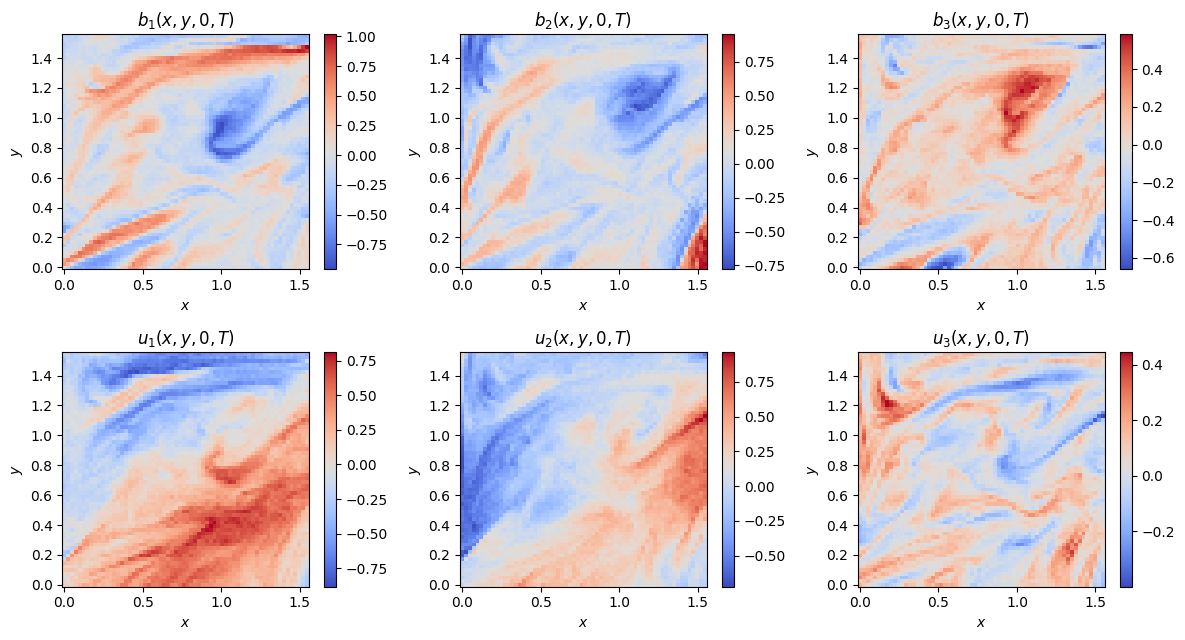

In [24]:
# Plot the different fields
X,Y = torch.meshgrid(x, y, indexing='ij')
fig, axes = plt.subplots(2, 3, figsize=(12, 6.5))

# Magnetic field
B = [Bx, By, Bz]
b_titles = ["$b_1(x,y,0,T)$", "$b_2(x,y,0,T)$", "$b_3(x,y,0,T)$"]

for i in range(3):
  ax = axes[0, i]
  pcm = ax.pcolormesh(X, Y, B[i][:,:,0,-1], cmap='coolwarm')
  fig.colorbar(pcm, ax=ax)
  ax.set_xlabel('$x$')
  ax.set_ylabel('$y$')
  ax.set_title(b_titles[i])

# Velocity field
U = [Ux, Uy, Uz]
u_titles = ["$u_1(x,y,0,T)$", "$u_2(x,y,0,T)$", "$u_3(x,y,0,T)$"]

for i in range(3):
  ax = axes[1, i]
  pcm = ax.pcolormesh(X, Y, U[i][:,:,0,-1], cmap='coolwarm')
  fig.colorbar(pcm, ax=ax)
  ax.set_xlabel('$x$')
  ax.set_ylabel('$y$')
  ax.set_title(u_titles[i])

plt.tight_layout()
plt.show()

del X, Y, fig, ax
del b_titles, u_titles, pcm

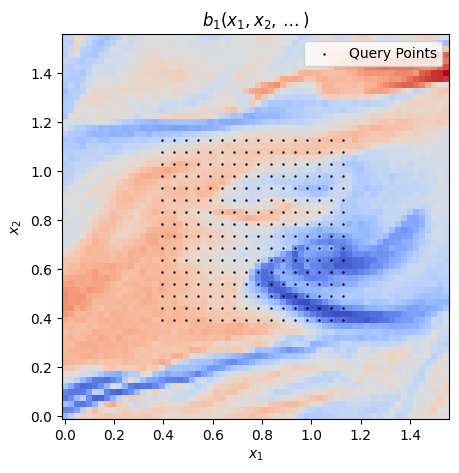

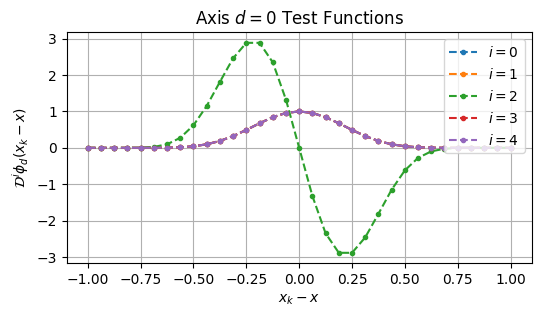

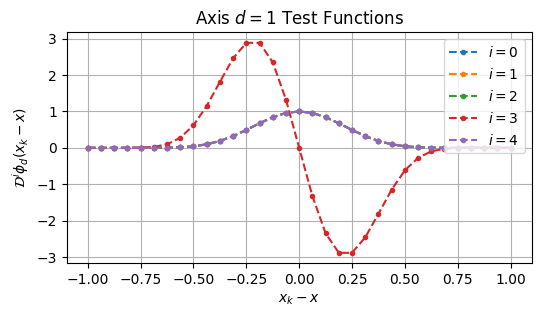

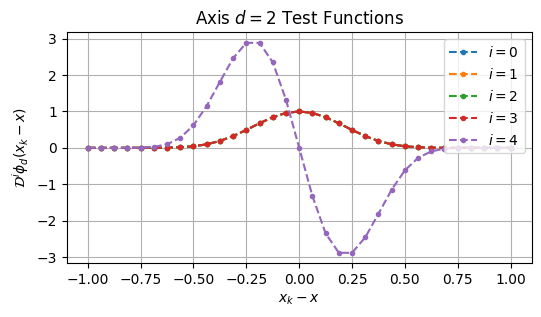

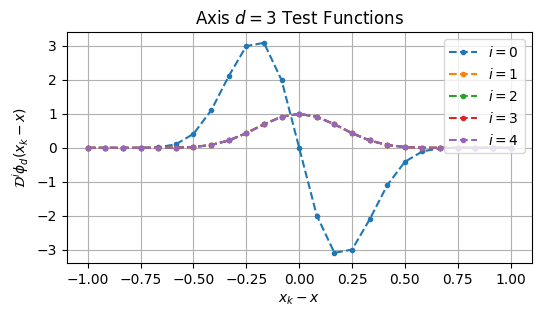

In [25]:
# Make a model for each b_i
V = [[By,Bz,Ux,Uy,Uz],
     [Bx,Bz,Ux,Uy,Uz],
     [Bx,By,Ux,Uy,Uz]]
names = [['b_1','b_2','b_3','u_1','u_2','u_3'],
         ['b_2','b_1','b_3','u_1','u_2','u_3'],
         ['b_3','b_1','b_2','u_1','u_2','u_3']]

X = [x,y,z,t]

# Derivatives for test fcns
alpha = [[0,0,0,1],
         [0,0,0,0],
         [1,0,0,0],
         [0,1,0,0],
         [0,0,1,0]]

# Powers for homogeneous fcns
beta = [[0,0,0, 0,0,0],
        [1,0,0, 0,0,0],
        [0,1,0, 0,0,0],
        [0,0,1, 0,0,0],
        # b_i * u_n combos
        [1,0,0, 1,0,0],
        [1,0,0, 0,1,0],
        [1,0,0, 0,0,1],
        # b_j * u_n combos
        [0,1,0, 1,0,0],
        [0,1,0, 0,1,0],
        [0,1,0, 0,0,1],
        # b_k * u_n combos
        [0,0,1, 1,0,0],
        [0,0,1, 0,1,0],
        [0,0,1, 0,0,1]]

# Test fcn support radii
m = [16, 16, 16, 12]

# Query point spacing
s = [2, 2, 2, 1]

b1_model = WSINDy(Bx, alpha, beta, X, V=V[0], names=names[0], m=m, s=s)
b2_model = WSINDy(By, alpha, beta, X, V=V[1], names=names[1], m=m, s=s, verbosity=False)
b3_model = WSINDy(Bz, alpha, beta, X, V=V[2], names=names[2], m=m, s=s, verbosity=False)

In [26]:
from IPython.display import display,Math

# Create standard library terms
[G,powers,derivs,rhs_names] = b1_model.create_default_library()

# Display the library in LaTeX
lib_string = r'\Theta=' + r'\{' + r', \, '.join(rhs_names) + r'\}'
display(Math(lib_string))

100%|██████████| 4/4 [00:59<00:00, 14.84s/it]


<IPython.core.display.Math object>

In [27]:
pdes = []
for i,model in enumerate([b1_model, b2_model, b3_model]):
  # Set lhs
  bi = ['(b_1)', '(b_2)', '(b_3)'][i]
  model.build_lhs(bi + b1_model.derivative_names[0])

  # Set library
  model.set_library(G, powers, derivs, rhs_names)

  # Find sparse weights
  _ = model.MSTLS()
  pde = symbolic_pde(model.lhs_name, model.rhs_names, model.coeffs)
  pdes.append(pde)

b1_model.print_report()

HYPER-PARAMETERS
m = [16, 16, 16, 12]
p = [11, 11, 11, 13]
s = [2, 2, 2, 1]
[yx, yt] = [2.546, 2.546, 2.546, 0.833]
yu = 1.000
Aux. scales = [1.0, 1.0, 1.0, 1.0, 1.0]

LIBRARY
Num. query points = 8192
Num. terms = 49
cond(G) = 1.450e+03

RESULTS
PDE: (b_1)_{t} = - 1.00(b_1 u_2)_{y} + 0.99(b_2 u_1)_{y} - 1.00(b_1 u_3)_{z} + 1.00(b_3 u_1)_{z}
Nonzero terms = 4
Rel. L2 error = 0.024
R^2 = 0.999
Lambda = 1.048e-01
Loss = 0.102


In [28]:
for pde in pdes:
  display(Math(pde))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Recall that \begin{align*}
\nabla \times (\boldsymbol{u} \times \boldsymbol{b}) &=
\begin{bmatrix}
(b_2u_1)_y-(b_1u_2)_y - (b_1u_3)_z + (b_3u_1)_z
\\
(b_3u_2)_z-(b_2u_3)_z - (b_2u_1)_x + (b_1u_2)_x
\\
(b_1u_3)_x-(b_3u_1)_x - (b_3u_2)_y + (b_2u_3)_y
\end{bmatrix}.
\end{align*}

In [29]:
# Reset variables
%reset -f